<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration04/dcgan_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  주요 라이브러리 버전을 확인
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [ ]:
# 라이브러리 및 모듈 임포트
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터셋 구성
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()
print(train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

(50000, 32, 32, 3)
max pixel: 255
min pixel: 0


In [ ]:
# 정규화
train_x = (train_x / 255.0) * 2 - 1
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


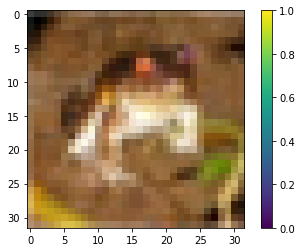

In [ ]:
# 첫 번째 데이터 확인
plt.imshow((train_x[0] + 1) / 2.0)
plt.colorbar()
plt.show()

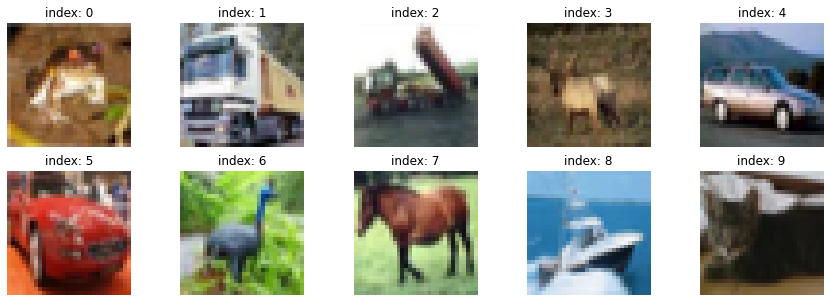

In [ ]:
# 10개 데이터 확인
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
# 버퍼 및 배치 크기 설정
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
# 학습 데이터셋에 미니 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# GAN generator model 함수
def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((8, 8, 256)))
	assert model.output_shape == (None, 8, 8, 256) # 주목: 배치사이즈로 None이 주어집니다.
	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	assert model.output_shape == (None, 8, 8, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fourth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 16, 16, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
	assert model.output_shape == (None, 32, 32, 3)
	return model

In [ ]:
# 생성 모델을 generator라는 변수로 생성, summary 출력
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

In [ ]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [ ]:
# 지금은 학습하는 중이 아니니 training=False로 설정
generated_image = generator(noise, training=False)
generated_image.shape


TensorShape([1, 32, 32, 3])

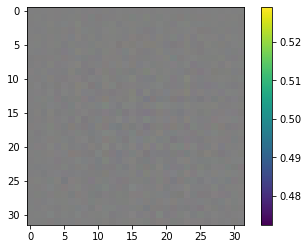

In [ ]:
# generated_image 출력
plt.imshow((generated_image[0] + 1) / 2.0)
plt.colorbar()
plt.show()

In [ ]:
# GAN discriminator model 함수
def make_discriminator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Conv2D Layer
	# 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
	model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Second: Conv2D Layer
	# 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Third: Flatten Layer
	model.add(layers.Flatten())

	# Fourth: Dense Layer
	# 이미지가 실제인지 (1에 가까운 값) 아니면 가짜인지 (0에 가까운 값)를 판별
	model.add(layers.Dense(1))

	return model

In [ ]:
# 판별 모델을 discriminator라는 변수로 생성, summary 출력
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [ ]:
# 가짜 이미지를 판별자에 입력시킨 결과 출력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00010693]], dtype=float32)>

In [ ]:
# 손실함수 설정
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)